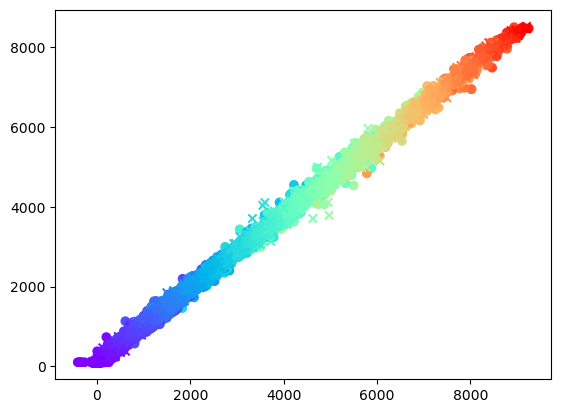

/kaggle/working/predicted_values.csv

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# load the data
train_df = pd.read_csv("/kaggle/input/dsai-uol-enappsys/train.csv")
test_df = pd.read_csv("/kaggle/input/dsai-uol-enappsys/test.csv")
X_train = train_df.drop(columns=['Id', 'y'])
y_train = train_df['y']
X_test = test_df.drop(columns=['Id'])

# create base models
gb1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb2 = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42)
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# define blending model
blender = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# define stacking variables
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
X_stack_train = np.zeros((X_train.shape[0], 3))
X_stack_test = np.zeros((X_test.shape[0], 3))
y_stack_train = y_train.values

# train and predict with base models for stacking
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_kf_train, X_kf_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]

    gb1.fit(X_kf_train, y_kf_train)
    gb2.fit(X_kf_train, y_kf_train)
    rf.fit(X_kf_train, y_kf_train)

    X_stack_train[test_index, 0] = gb1.predict(X_kf_test)
    X_stack_train[test_index, 1] = gb2.predict(X_kf_test)
    X_stack_train[test_index, 2] = rf.predict(X_kf_test)

    X_stack_test[:, 0] += gb1.predict(X_test)
    X_stack_test[:, 1] += gb2.predict(X_test)
    X_stack_test[:, 2] += rf.predict(X_test)

X_stack_test /= n_splits

# train the blending model on stacked data
blender.fit(X_stack_train, y_stack_train)

# make predictions with blender on stacked test data
y_pred_stack = blender.predict(X_stack_test)

# save the predictions to a csv file
pred_df = pd.DataFrame({'Id': test_df['Id'], 'y': y_pred_stack})
pred_df.to_csv('predicted_values.csv', index=False)

# visualize the predicted data
import matplotlib.pyplot as plt
plt.scatter(X_stack_train[:, 0], X_stack_train[:, 1], c=y_train, cmap='rainbow')
plt.scatter(X_stack_test[:, 0], X_stack_test[:, 1], c=y_pred_stack, cmap='rainbow', marker='x')
plt.show()

from IPython.display import FileLink
FileLink(r'predicted_values.csv')